# M5 Forecasting - DIY StatsForecast

Training and evaluating forecasting models on the M5 dataset using StatsForecast.

## 1. Setup & Imports

In [178]:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoTheta
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

data_dir = Path('./data')
# Create results directory
results_dir = Path('./results')
results_dir.mkdir(exist_ok=True)

print("Imports OK. Ready to train M5 models.")

Imports OK. Ready to train M5 models.


## 2. Load M5 Data

In [179]:
from datasetsforecast.m5 import M5 

data = M5()
data, events, meta = data.load(data_dir)

In [180]:
# upsample this data for faster training purposes 

week_df = data.groupby(
    [pd.Grouper(key='ds',freq='W-SAT'),"unique_id"],as_index=False,
)[['y']].sum()

## 5. Configure Models

In [185]:
from statsforecast.models import SeasonalNaive, SimpleExponentialSmoothingOptimized
from models import SeasonalNaiveWDrift,PyDLM
from pydlm import trend, seasonality, autoReg,longSeason
from functools import partial 

# define pyDLM, we can build different models using various components! 
# discount is how much we allow these params to change over time

local_level = [trend(degree=0,discount=.8,name='Level')]
local_level_trend = [trend(degree=1,discount=.98,name='Trend')]
local_level_trend_seasonal = local_level_trend + [seasonality(period=52,discount=.995,name='Seasonal52')]
local_level_mo_seasonal = local_level + [seasonality(period=12,discount=.995,name='Seasonal52')]


# StatsForecast models
stat_models = [

    SeasonalNaive(season_length=52),

    SimpleExponentialSmoothingOptimized(),

    SeasonalNaiveWDrift(season_length=52),

   PyDLM(model_components=local_level,alias='LocalLevel'),

  PyDLM(model_components=local_level_trend,alias='LevelTrend'),

  PyDLM(model_components=local_level_mo_seasonal,alias='LevelMonthlySeasonal'),

  PyDLM(model_components=local_level_trend_seasonal,alias='LevelTrendSeasonal'),
]

## 6. Train StatsForecast Models

In [186]:
subset = week_df.loc[week_df['unique_id'].isin(week_df['unique_id'].sample(500))]

In [187]:
# setup CV config 
h = 13
n_windows = 4
cv_config = dict(n_windows=n_windows,step_size=h,h=h)

In [188]:
#train models 
sf = StatsForecast(models=stat_models, freq='W-SAT',n_jobs=-1)


stat_forecasts = sf.cross_validation(
    df = week_df,
    **cv_config 
)

print(f"✓ StatsForecast predictions shape: {stat_forecasts.shape}")
print(f"  Columns: {list(stat_forecasts.columns)}")

✓ StatsForecast predictions shape: (1585480, 11)
  Columns: ['unique_id', 'ds', 'cutoff', 'y', 'SeasonalNaive', 'SESOpt', 'SeasonalNaiveWDrift', 'LocalLevel', 'LevelTrend', 'LevelMonthlySeasonal', 'LevelTrendSeasonal']


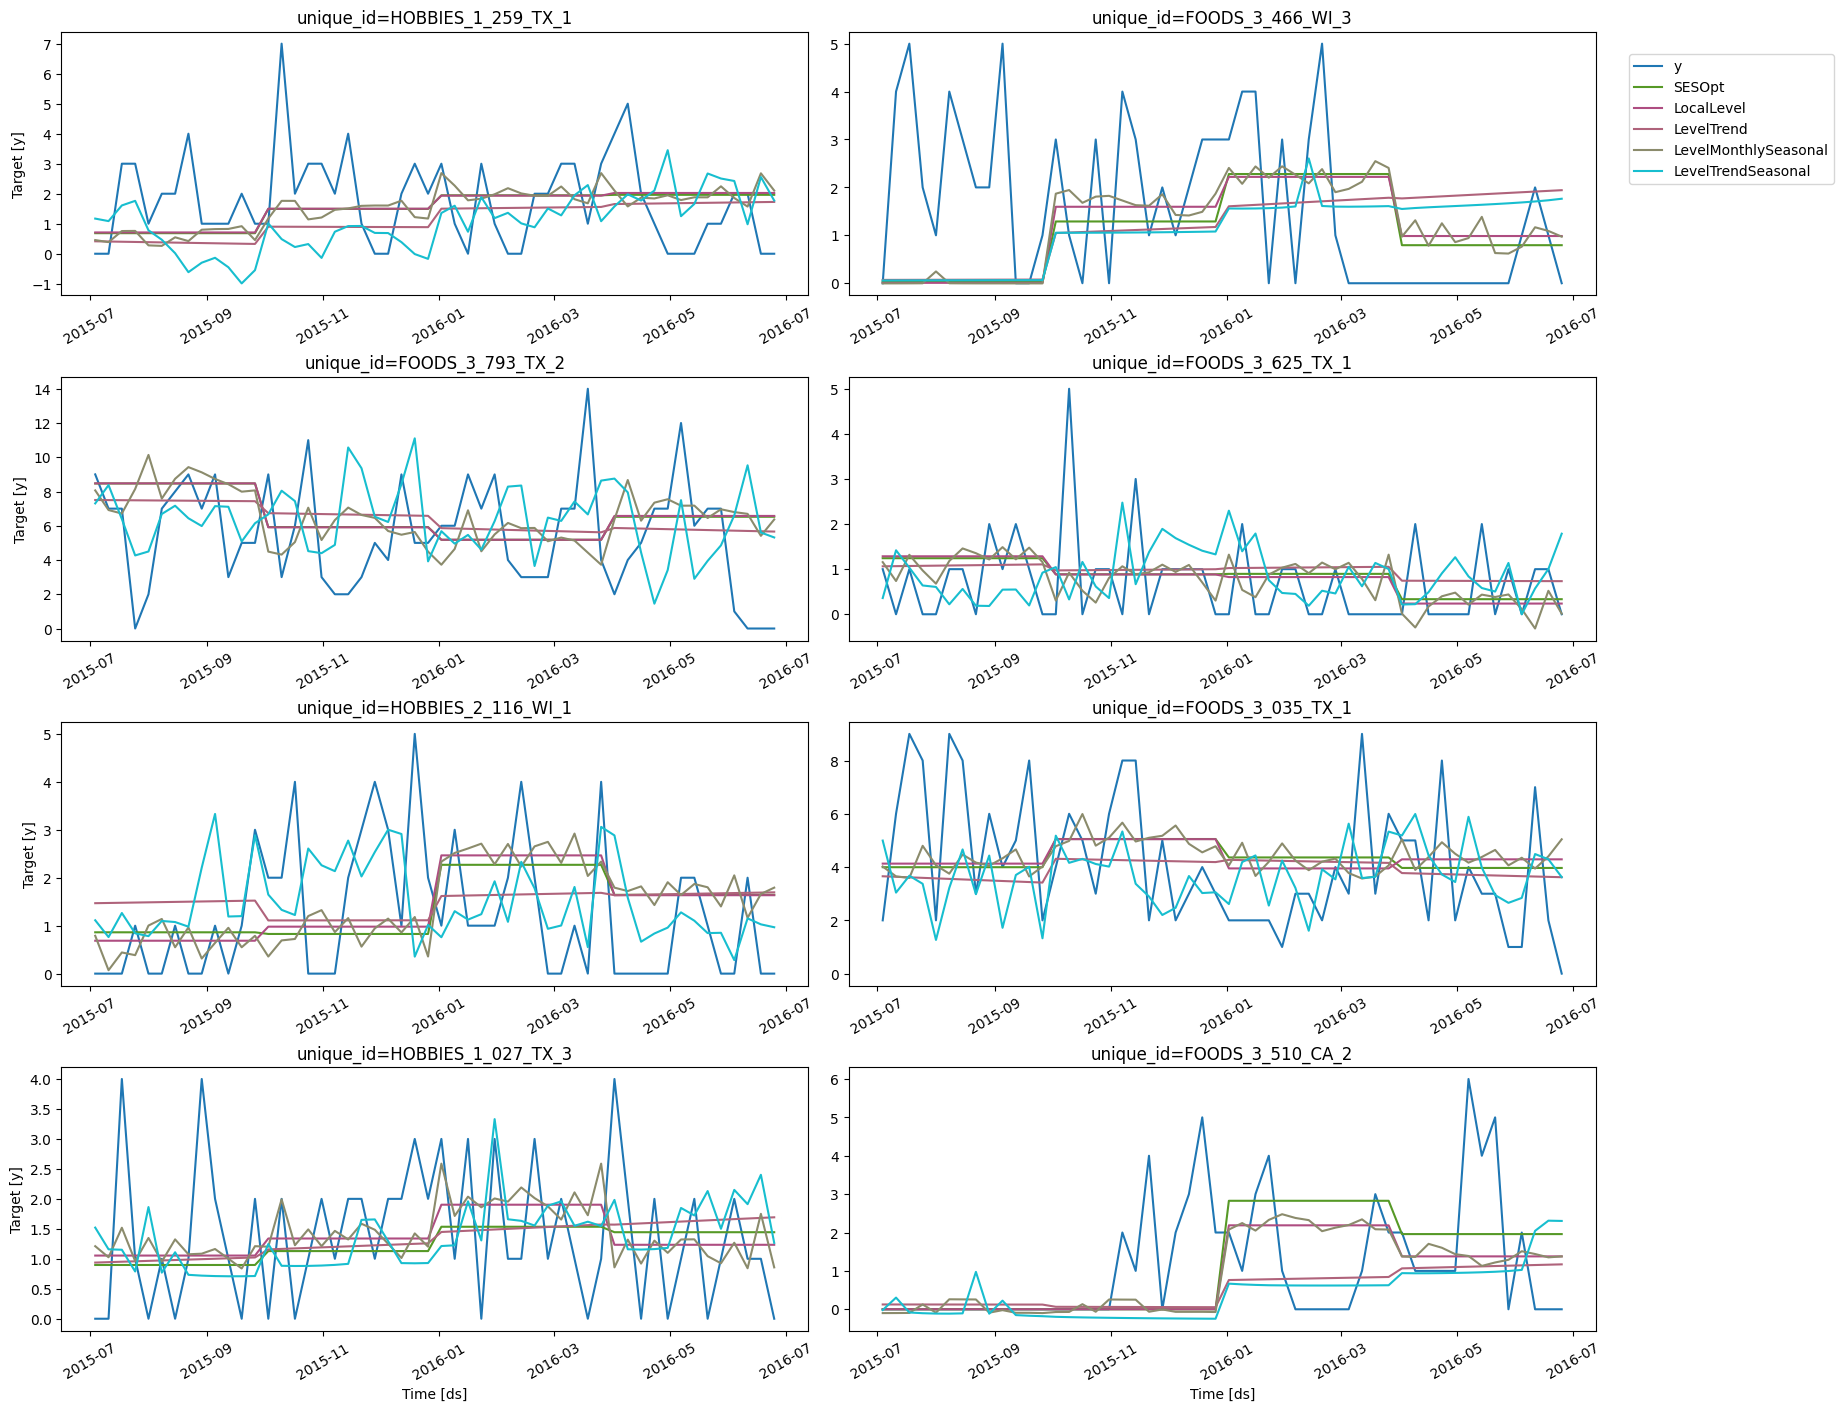

In [190]:
from utilsforecast.plotting import plot_series

plot_series(forecasts_df=stat_forecasts,models=['SESOpt','LocalLevel','LevelTrend','LevelMonthlySeasonal', 'LevelTrendSeasonal'],seed=np.random.seed(42))

In [191]:
from utilsforecast.evaluation import evaluate 
from utilsforecast.losses import nd, bias,rmae
from functools import partial

MODELS = [model.alias for model in sf.models]

print(f'Evaluating Models: {MODELS}')

results = evaluate(
df=stat_forecasts.assign(lit = '1'),
models=MODELS,
metrics=[mae,bias,partial(rmae,baseline='SESOpt')],
id_col='lit',
)


mae_bias_df = results.groupby('cutoff',as_index=False)[MODELS].agg(lambda x: x.abs().sum())

results.head()

Evaluating Models: ['SeasonalNaive', 'SESOpt', 'SeasonalNaiveWDrift', 'LocalLevel', 'LevelTrend', 'LevelMonthlySeasonal', 'LevelTrendSeasonal']


,lit,cutoff,metric,SeasonalNaive,SESOpt,SeasonalNaiveWDrift,LocalLevel,LevelTrend,LevelMonthlySeasonal,LevelTrendSeasonal
0,1,2015-06-27,mae,6.197843,4.208962,6.551765,4.261127,4.732780,4.391129,5.197204
1,1,2015-09-26,mae,5.697752,4.582995,5.989099,4.564185,4.665237,4.662245,4.939013
2,1,2015-12-26,mae,6.084063,4.630151,6.326079,4.387234,4.577744,4.488983,5.126333
3,1,2016-03-26,mae,6.294339,4.608544,6.633385,4.552824,4.841876,4.653941,5.325940
4,1,2015-06-27,bias,-0.623511,-0.496065,0.468851,-0.562903,-0.639254,-0.554787,-0.337717


# Now we plot the MAE and BIAS over the cutoffs

    * here we use MAE instead of WMAPE as Nixtla's Bias function computes bias in units, not as a %! 

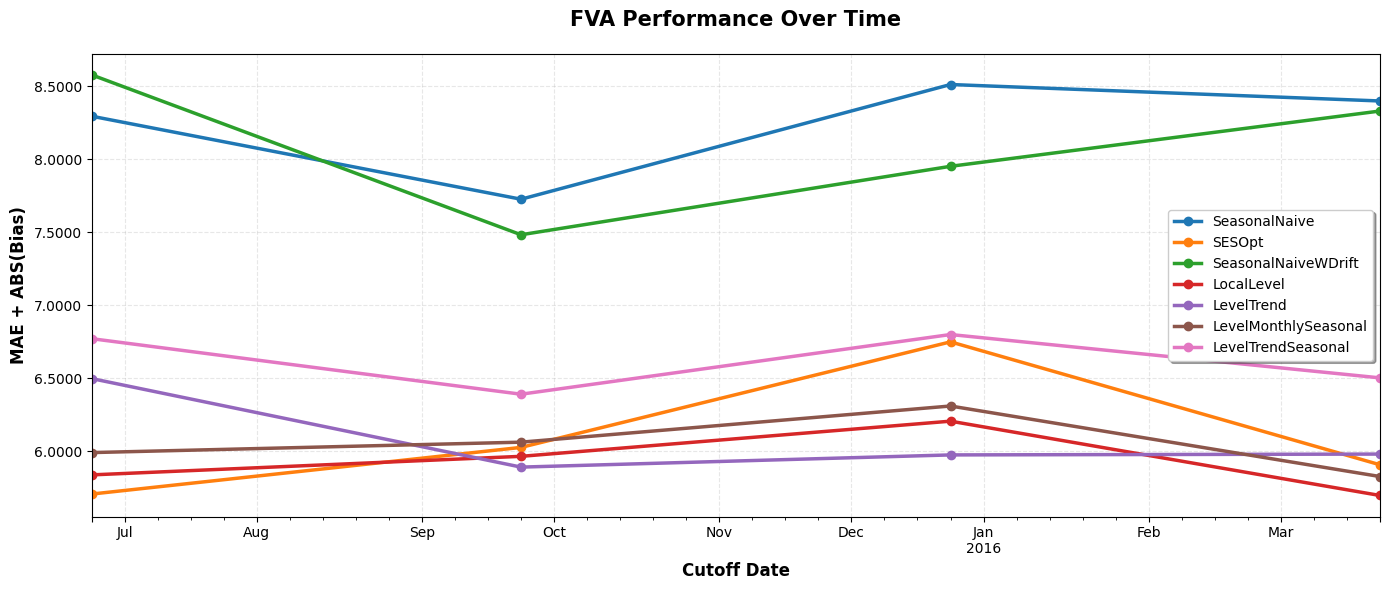

In [192]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 6))


# Plot each model (excluding AR1)
for model in MODELS:
    if "AR1" in model:
        continue 

    mae_bias_df.plot(
        x='cutoff', 
        y=model, 
        ax=ax, 
        marker='o', 
        linestyle='-',
        linewidth=2.5,
        markersize=6,
        label=model
    )

# Styling
ax.set_title('FVA Performance Over Time', fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel('Cutoff Date', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE + ABS(Bias)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=10)

# Format y-axis to 4 decimals
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.4f}'))

plt.tight_layout()
plt.show()

# Examine the MAE relative to SESOptimized.
    * I threw this in as 90% of contestants in the M5 competition couldn't beat SES, so this is a great benchmark on this data. 

In [193]:
results.query('metric == "rmae_SESOpt"').style.background_gradient(cmap='Blues_r',)

,lit,cutoff,metric,SeasonalNaive,SESOpt,SeasonalNaiveWDrift,LocalLevel,LevelTrend,LevelMonthlySeasonal,LevelTrendSeasonal
8,1,2015-06-27 00:00:00,rmae_SESOpt,1.472535,1.000000,1.556622,1.012394,1.124453,1.043281,1.234795
9,1,2015-09-26 00:00:00,rmae_SESOpt,1.243238,1.000000,1.306809,0.995896,1.017945,1.017292,1.077682
10,1,2015-12-26 00:00:00,rmae_SESOpt,1.314010,1.000000,1.366279,0.947536,0.988681,0.969511,1.107163
11,1,2016-03-26 00:00:00,rmae_SESOpt,1.365798,1.000000,1.439367,0.987909,1.050630,1.009851,1.155666
